In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df = pd.read_csv('portland-oregon-average-monthly-.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)
df.drop(df.index[114], inplace=True)

In [4]:
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [5]:
df.columns= ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)

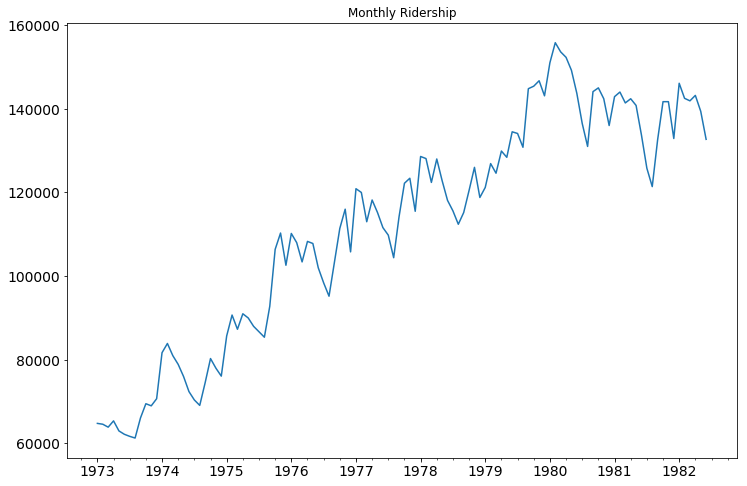

In [6]:
df.riders.plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14)
plt.savefig('month_ridership.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

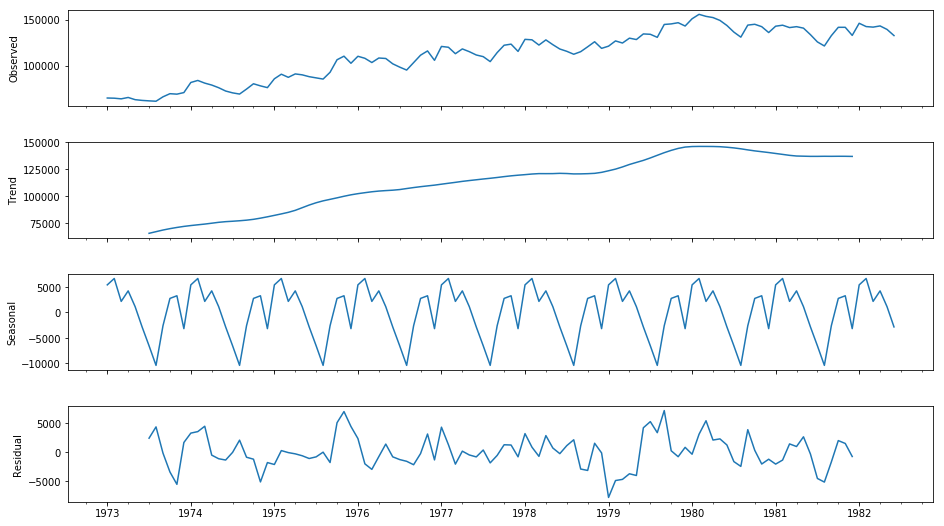

In [7]:
decomposition = seasonal_decompose(df.riders, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Results of Dickey-Fuller Test:')? (<ipython-input-8-24dcc4c334ae>, line 18)

In [31]:
test_stationarity(df.riders)

NameError: name 'test_stationarity' is not defined

In [10]:
df.riders_log= df.riders.apply(lambda x: np.log(x))  
test_stationarity(df.riders_log)

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


NameError: name 'test_stationarity' is not defined

In [11]:
df['first_difference'] = df.riders - df.riders.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))

NameError: name 'test_stationarity' is not defined

In [12]:
df['log_first_difference'] = df.riders_log - df.riders_log.shift(1)  
test_stationarity(df.log_first_difference.dropna(inplace=False))

NameError: name 'test_stationarity' is not defined

In [13]:
df['seasonal_difference'] = df.riders - df.riders.shift(12)  
test_stationarity(df.seasonal_difference.dropna(inplace=False))

NameError: name 'test_stationarity' is not defined

In [14]:
df['log_seasonal_difference'] = df.riders_log - df.riders_log.shift(12)  
test_stationarity(df.log_seasonal_difference.dropna(inplace=False))

NameError: name 'test_stationarity' is not defined

In [15]:
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

NameError: name 'test_stationarity' is not defined

In [16]:
df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)  
test_stationarity(df.log_seasonal_first_difference.dropna(inplace=False))

NameError: name 'test_stationarity' is not defined

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


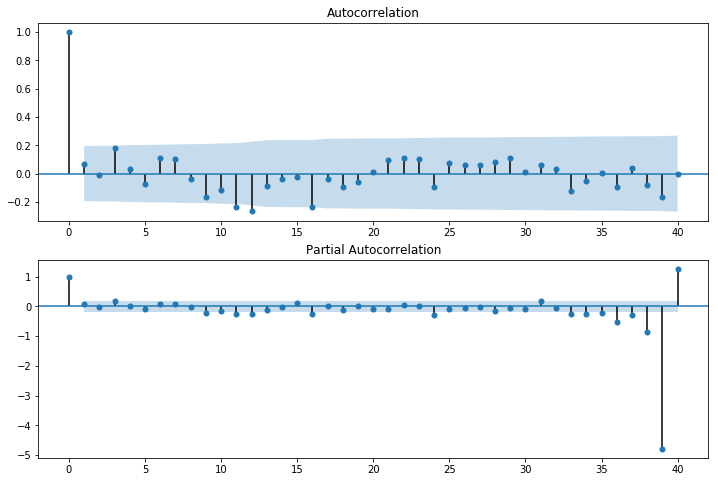

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [20]:
mod1 = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(0,1,1,12))
results1 = mod1.fit()
print(results1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -976.135
Date:                            Tue, 18 Jun 2019   AIC                           1956.271
Time:                                    18:29:38   BIC                           1961.501
Sample:                                01-01-1973   HQIC                          1958.388
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1377      0.050     -2.757      0.006      -0.236      -0.040
sigma2      1.424e+07   2.62e-10   

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [21]:
mod2 = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results2 = mod2.fit()
print(results2.summary())

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -970.257
Date:                            Tue, 18 Jun 2019   AIC                           1946.515
Time:                                    18:30:06   BIC                           1954.360
Sample:                                01-01-1973   HQIC                          1949.691
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5589      0.084      6.654      0.000       0.394       0.724
ma.S.L12      -0.9951      0.118   

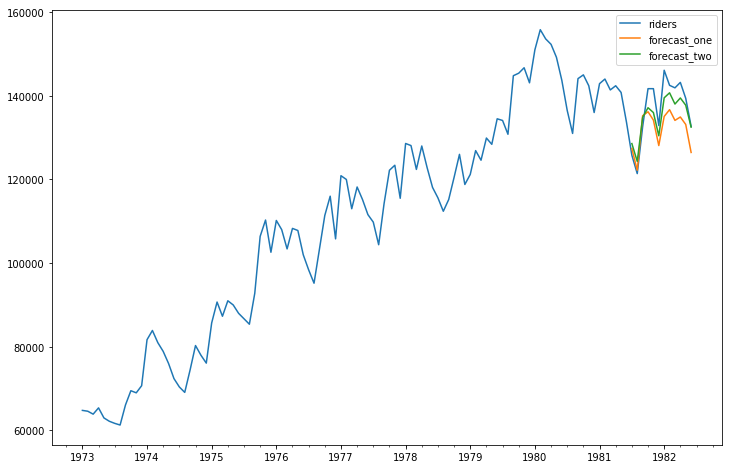

In [23]:
df['forecast_one'] = results1.predict(start = 102, end= 114, dynamic= True)
df['forecast_two'] = results2.predict(start = 102, end= 114, dynamic= True)  
df[['riders', 'forecast_one', 'forecast_two']].plot(figsize=(12, 8)) 
plt.savefig('ts_df_predict.png', bbox_inches='tight')

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


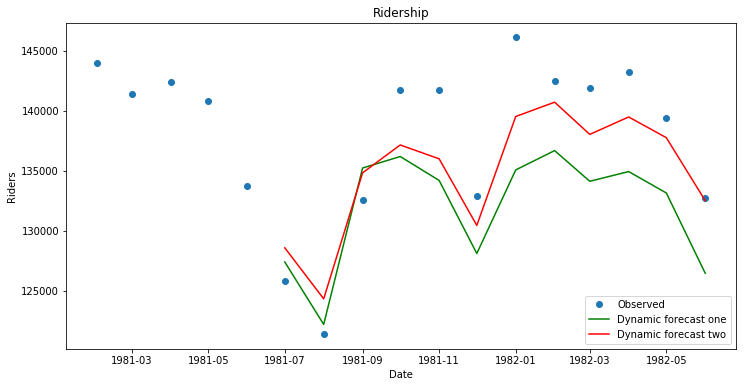

In [26]:
npredict =df.riders['1982'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Ridership', xlabel='Date', ylabel='Riders')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'riders'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast_one'], 'g', label='Dynamic forecast one')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast_two'], 'r', label='Dynamic forecast two')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')
plt.savefig('ts_predict_compare.png', bbox_inches='tight')

In [27]:
start = datetime.datetime.strptime("1982-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df = pd.concat([df, future])

/Users/apeeblesmadigan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


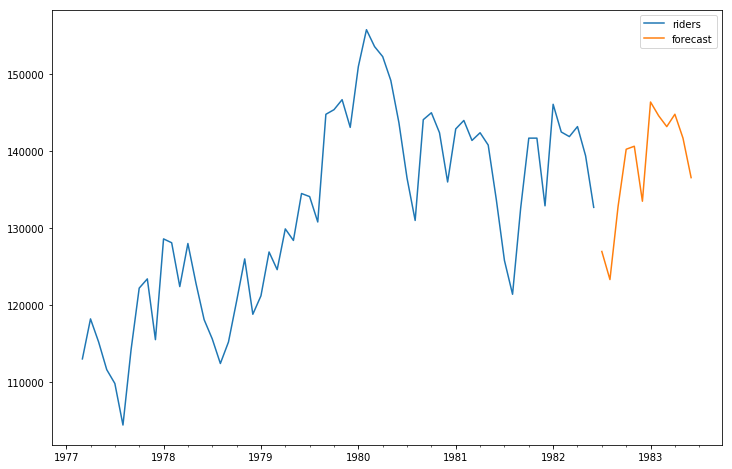

In [30]:
df['forecast'] = results2.predict(start = 114, end = 125, dynamic= True)  
df[['riders', 'forecast']].ix[-76:].plot(figsize=(12, 8)) 
plt.savefig('ts_predict_future.png', bbox_inches='tight')

In [25]:
## A little extra I was doing to try and include an exogenous variable for number of weekdays in each month.
## Thinking that people take public transportation more during the week, a count of weekdays in each month could help explain some of the variance.  

start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
moving = start
d = {}
year =0
month =0
while moving < datetime.datetime(1982,7,1):
#     print moving
    if moving.year == year:
        if moving.month == month:
            if moving.weekday() < 5:
                d[str(moving.year)+"-"+ str(moving.month)] += 1
        else:
            d[str(moving.year)+"-"+ str(moving.month)]=0
            if moving.weekday() < 5:
                d[str(moving.year)+"-"+ str(moving.month)] += 1
    else:
#         d[moving.year] = {}
        d[str(moving.year)+"-"+ str(moving.month)]=0
        if moving.weekday() < 5:
            d[str(moving.year)+"-"+ str(moving.month)] += 1


    year = moving.year
    month = moving.month
    moving += datetime.timedelta(days=1)
df_dow = pd.DataFrame(d.items(), columns=['Month', 'DateValue'])
df_dow.Month = pd.to_datetime(df_dow.Month)
df_dow.sort('Month', inplace=True)

def holiday_adj(x):
    if x['Month'].month==1:
        x['DateValue'] -=1
        return x['DateValue'] 
    elif x['Month'].month==2:
        x['DateValue'] -=1
        return x['DateValue']
    elif x['Month'].month==5:
        x['DateValue'] -=1
        return x['DateValue']
    elif x['Month'].month==7:
        x['DateValue'] -=1
        return x['DateValue']
    elif x['Month'].month==9:
        x['DateValue'] -=1
        return x['DateValue']
    elif x['Month'].month==10:
        x['DateValue'] -=1
        return x['DateValue']    
    elif x['Month'].month==11:
        x['DateValue'] -=3   
        return x['DateValue']
    elif x['Month'].month==12:
        x['DateValue'] -=2
        return x['DateValue']

    else:
        return x['DateValue']
    
df_dow['days'] = df_dow.apply(holiday_adj, axis=1)
df_dow.set_index('Month', inplace=True)
df_dow.index.name = None

/Users/seanwilson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
